# Quasi-recurrent neural networks - 


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('TensorFlow Version: {}'.format(tf.__version__))

Found GPU at: /device:GPU:0
TensorFlow Version: 1.10.0


<a id='download'></a>

## Downloading dataset

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Dense, Embedding, Dropout
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout
from keras.layers import LSTM, GRU, RepeatVector
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers import Conv1D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.optimizers import Adam
from keras import objectives
from keras import activations
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
def show_images(images):
    import matplotlib.gridspec as gridspec
    
    sqrtn = int(np.ceil(np.sqrt(len(images))))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img[:,:,0], cmap='gray')
    plt.show()
    

class dataset_batches():
    def __init__(self, x_train, shuffle=True):
        self.shuffle = shuffle
        self.x_train = self.scale(x_train)
        
    def batches(self, batch_size):
        n = len(self.x_train)
        if self.shuffle:
            idx = np.arange(n)
            np.random.shuffle(idx)
            self.x_train = self.x_train[idx]
            
        n_batches = n // batch_size
        for i in range(0, n, batch_size):
            yield self.x_train[i:i+batch_size]

    def scale(self, x_train):
        return x_train * 2 - 1

In [0]:
def load_mnist_data(dim):
    from keras.datasets import mnist
    from keras.utils import to_categorical
    num_classes = 10
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    print(len(X_train), 'train samples')
    print(len(X_test), 'test samples')
    
    if dim == 3:
        if K.image_data_format() == 'channels_first':
            X_train = X_train.reshape(len(X_train), 1, 28, 28)
            X_test = X_test.reshape(len(X_test), 1, 28, 28)
        else:
            X_train = X_train.reshape(len(X_train), 28, 28, 1)
            X_test = X_test.reshape(len(X_test), 28, 28, 1)
    elif dim == 1:
        X_train = X_train.reshape(len(X_train), -1)
        X_test = X_test.reshape(len(X_test), -1)

    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    # convert class vectors to binary class matrices
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_mnist_data(dim=2)

11493376/11490434 [==============================] - 1s 0us/step
60000 train samples
10000 test samples
X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


In [0]:
def get_imdb_data(maxlen=100, max_features=20000):
    from keras.datasets import imdb
    from keras.preprocessing import sequence
    
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
    print(len(X_train), 'train sequences')
    print(len(X_test), 'test sequences')
    
    print('... Padding sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)
    
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = get_imdb_data()

17465344/17464789 [==============================] - 3s 0us/step
25000 train sequences
25000 test sequences
... Padding sequences (samples x time)
X_train shape: (25000, 100)
X_test shape: (25000, 100)


### Other datasets

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
list_sentences_train = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/train.csv').values
list_sentences_test = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/test.csv').values

In [0]:
# Sequence Generation¶
# Here we take the data and generate sequences from the data

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
# train data
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
# test data
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

## QRNN layer

In [0]:
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.layers import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length


def _dropout(x, level, noise_shape=None, seed=None):
    x = K.dropout(x, level, noise_shape, seed)
    x *= (1. - level) # compensate for the scaling by the dropout
    return x


class QRNN(Layer):
    '''Quasi RNN
    # Arguments
        units: dimension of the internal projections and the final output.
    # References
        - [Quasi-recurrent Neural Networks](http://arxiv.org/abs/1611.01576)
    '''
    def __init__(self, units, window_size=2, stride=1,
                 return_sequences=False, go_backwards=False, 
                 stateful=False, unroll=False, activation='tanh',
                 kernel_initializer='uniform', bias_initializer='zero',
                 kernel_regularizer=None, bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, 
                 dropout=0, use_bias=True, input_dim=None, input_length=None,
                 **kwargs):
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards
        self.stateful = stateful
        self.unroll = unroll

        self.units = units 
        self.window_size = window_size
        self.strides = (stride, 1)

        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = dropout
        self.supports_masking = True
        self.input_spec = [InputSpec(ndim=3)]
        self.input_dim = input_dim
        self.input_length = input_length
        if self.input_dim:
            kwargs['input_shape'] = (self.input_length, self.input_dim)
        super(QRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        self.input_dim = input_shape[2]
        self.input_spec = InputSpec(shape=(batch_size, None, self.input_dim))
        self.state_spec = InputSpec(shape=(batch_size, self.units))

        self.states = [None]
        if self.stateful:
            self.reset_states()

        kernel_shape = (self.window_size, 1, self.input_dim, self.units * 3)
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(name='bias', 
                                        shape=(self.units * 3,),
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)

        self.built = True

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        length = input_shape[1]
        if length:
            length = conv_output_length(length + self.window_size - 1,
                                        self.window_size, 'valid',
                                        self.strides[0])
        if self.return_sequences:
            return (input_shape[0], length, self.units)
        else:
            return (input_shape[0], self.units)

    def compute_mask(self, inputs, mask):
        if self.return_sequences:
            return mask
        else:
            return None

    def get_initial_states(self, inputs):
        # build an all-zero tensor of shape (samples, units)
        initial_state = K.zeros_like(inputs)  # (samples, timesteps, input_dim)
        initial_state = K.sum(initial_state, axis=(1, 2))  # (samples,)
        initial_state = K.expand_dims(initial_state)  # (samples, 1)
        initial_state = K.tile(initial_state, [1, self.units])  # (samples, units)
        initial_states = [initial_state for _ in range(len(self.states))]
        return initial_states

    def reset_states(self, states=None):
        if not self.stateful:
            raise AttributeError('Layer must be stateful.')
        if not self.input_spec:
            raise RuntimeError('Layer has never been called '
                               'and thus has no states.')

        batch_size = self.input_spec.shape[0]
        if not batch_size:
            raise ValueError('If a QRNN is stateful, it needs to know '
                             'its batch size. Specify the batch size '
                             'of your input tensors: \n'
                             '- If using a Sequential model, '
                             'specify the batch size by passing '
                             'a `batch_input_shape` '
                             'argument to your first layer.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a '
                             '`batch_shape` argument to your Input layer.')

        if self.states[0] is None:
            self.states = [K.zeros((batch_size, self.units))
                           for _ in self.states]
        elif states is None:
            for state in self.states:
                K.set_value(state, np.zeros((batch_size, self.units)))
        else:
            if not isinstance(states, (list, tuple)):
                states = [states]
            if len(states) != len(self.states):
                raise ValueError('Layer ' + self.name + ' expects ' +
                                 str(len(self.states)) + ' states, '
                                 'but it received ' + str(len(states)) +
                                 'state values. Input received: ' +
                                 str(states))
            for index, (value, state) in enumerate(zip(states, self.states)):
                if value.shape != (batch_size, self.units):
                    raise ValueError('State ' + str(index) +
                                     ' is incompatible with layer ' +
                                     self.name + ': expected shape=' +
                                     str((batch_size, self.units)) +
                                     ', found shape=' + str(value.shape))
                K.set_value(state, value)

    def __call__(self, inputs, initial_state=None, **kwargs):
        # If `initial_state` is specified,
        # and if it a Keras tensor,
        # then add it to the inputs and temporarily
        # modify the input spec to include the state.
        if initial_state is not None:
            if hasattr(initial_state, '_keras_history'):
                # Compute the full input spec, including state
                input_spec = self.input_spec
                state_spec = self.state_spec
                if not isinstance(state_spec, list):
                    state_spec = [state_spec]
                self.input_spec = [input_spec] + state_spec

                # Compute the full inputs, including state
                if not isinstance(initial_state, (list, tuple)):
                    initial_state = [initial_state]
                inputs = [inputs] + list(initial_state)

                # Perform the call
                output = super(QRNN, self).__call__(inputs, **kwargs)

                # Restore original input spec
                self.input_spec = input_spec
                return output
            else:
                kwargs['initial_state'] = initial_state
        return super(QRNN, self).__call__(inputs, **kwargs)

    def call(self, inputs, mask=None, initial_state=None, training=None):
        # input shape: `(samples, time (padded with zeros), input_dim)`
        # note that the .build() method of subclasses MUST define
        # self.input_spec and self.state_spec with complete input shapes.
        if isinstance(inputs, list):
            initial_states = inputs[1:]
            inputs = inputs[0]
        elif initial_state is not None:
            pass
        elif self.stateful:
            initial_states = self.states
        else:
            initial_states = self.get_initial_states(inputs)

        if len(initial_states) != len(self.states):
            raise ValueError('Layer has ' + str(len(self.states)) +
                             ' states but was passed ' +
                             str(len(initial_states)) +
                             ' initial states.')
        input_shape = K.int_shape(inputs)
        if self.unroll and input_shape[1] is None:
            raise ValueError('Cannot unroll a RNN if the '
                             'time dimension is undefined. \n'
                             '- If using a Sequential model, '
                             'specify the time dimension by passing '
                             'an `input_shape` or `batch_input_shape` '
                             'argument to your first layer. If your '
                             'first layer is an Embedding, you can '
                             'also use the `input_length` argument.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a `shape` '
                             'or `batch_shape` argument to your Input layer.')
        constants = self.get_constants(inputs, training=None)
        preprocessed_input = self.preprocess_input(inputs, training=None)

        last_output, outputs, states = K.rnn(self.step, preprocessed_input,
                                            initial_states,
                                            go_backwards=self.go_backwards,
                                            mask=mask,
                                            constants=constants,
                                            unroll=self.unroll,
                                            input_length=input_shape[1])
        if self.stateful:
            updates = []
            for i in range(len(states)):
                updates.append((self.states[i], states[i]))
            self.add_update(updates, inputs)

        # Properly set learning phase
        if 0 < self.dropout < 1:
            last_output._uses_learning_phase = True
            outputs._uses_learning_phase = True

        if self.return_sequences:
            return outputs
        else:
            return last_output

    def preprocess_input(self, inputs, training=None):
        if self.window_size > 1:
            inputs = K.temporal_padding(inputs, (self.window_size-1, 0))
        inputs = K.expand_dims(inputs, 2)  # add a dummy dimension

        output = K.conv2d(inputs, self.kernel, strides=self.strides,
                          padding='valid',
                          data_format='channels_last')
        output = K.squeeze(output, 2)  # remove the dummy dimension
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')

        if self.dropout is not None and 0. < self.dropout < 1.:
            z = output[:, :, :self.units]
            f = output[:, :, self.units:2 * self.units]
            o = output[:, :, 2 * self.units:]
            f = K.in_train_phase(1 - _dropout(1 - f, self.dropout), f, training=training)
            return K.concatenate([z, f, o], -1)
        else:
            return output

    def step(self, inputs, states):
        prev_output = states[0]

        z = inputs[:, :self.units]
        f = inputs[:, self.units:2 * self.units]
        o = inputs[:, 2 * self.units:]

        z = self.activation(z)
        f = f if self.dropout is not None and 0. < self.dropout < 1. else K.sigmoid(f)
        o = K.sigmoid(o)

        output = f * prev_output + (1 - f) * z
        output = o * output

        return output, [output]

    def get_constants(self, inputs, training=None):
        return []
 
    def get_config(self):
        config = {'units': self.units,
                  'window_size': self.window_size,
                  'stride': self.strides[0],
                  'return_sequences': self.return_sequences,
                  'go_backwards': self.go_backwards,
                  'stateful': self.stateful,
                  'unroll': self.unroll,
                  'use_bias': self.use_bias,
                  'dropout': self.dropout,
                  'activation': activations.serialize(self.activation),
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'input_dim': self.input_dim,
                  'input_length': self.input_length}
        base_config = super(QRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## First experiment

In [0]:
def build_model(input_length=100, max_features=20000, embed_size=300):
    inp = Input(shape=(input_length, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Dropout(0.25)(x)
    x = Conv1D(2*embed_size, kernel_size=3)(x)
    x = Conv1D(2*embed_size, kernel_size=3)(x)
    
    # strides rate we use here for skip
    for strides in [1, 1, 2]:
        x = QRNN(128*2**(strides), return_sequences=True, stride=strides, dropout=0.2)(x)
    x_f = QRNN(512)(x)  
    x_b = QRNN(512, go_backwards=True)(x)
    x = concatenate([x_f, x_b])
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

model = build_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 100, 300)     6000000     input_8[0][0]                    
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 100, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 98, 600)      540600      dropout_23[0][0]                 
__________________________________________________________________________________________________
conv1d_6 (

In [0]:
epochs = 10
batch_size = 1024

file_path = 'weights.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)

callbacks_list = [checkpoint, early]
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          #validation_split=0.25,
          validation_data=(X_test, y_test),
          callbacks=callbacks_list)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 80s 3ms/step - loss: 0.6658 - acc: 0.5628 - val_loss: 0.5951 - val_acc: 0.6783

Epoch 00001: val_loss improved from inf to 0.59508, saving model to weights.h5
Epoch 2/20
25000/25000 [==============================] - 77s 3ms/step - loss: 0.5021 - acc: 0.7580 - val_loss: 0.5929 - val_acc: 0.7167

Epoch 00002: val_loss improved from 0.59508 to 0.59291, saving model to weights.h5
Epoch 3/20
25000/25000 [==============================] - 77s 3ms/step - loss: 0.3720 - acc: 0.8364 - val_loss: 0.6533 - val_acc: 0.7058

Epoch 00003: val_loss did not improve from 0.59291
Epoch 4/20
25000/25000 [==============================] - 77s 3ms/step - loss: 0.2578 - acc: 0.8958 - val_loss: 0.8122 - val_acc: 0.6955

Epoch 00004: val_loss did not improve from 0.59291
Epoch 5/20
25000/25000 [==============================] - 77s 3ms/step - loss: 0.1593 - acc: 0.9370 - val_loss: 1.1707 - val_acc: 0.68

In [0]:
# from google.colab import files

# files.download('weights.h5') 

## Second experiment

In [0]:
def build_model(input_length=100, max_features=20000, embed_size=300):
    inputs = Input(shape=(input_length, ))
    x = Embedding(max_features, embed_size, trainable=False)(inputs)
    x = Dropout(0.3)(x)
    for _ in range(3):
        x = GRU(256, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        
    x = GRU(256)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 256)          427776    
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 256)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 256)          393984    
_________________________________________________________________
dropout_16 (Dropout)         (None, 100, 256)          0         
__________

In [0]:
epochs = 10
batch_size = 1024

file_path = 'weights.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model.fit(X_train, y_train,
          shuffle=True,
          batch_size=batch_size, 
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint, early])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 51s 2ms/step - loss: 0.6731 - acc: 0.5750 - val_loss: 0.6435 - val_acc: 0.6329

Epoch 00001: val_loss improved from inf to 0.64348, saving model to weights.h5
Epoch 2/10
25000/25000 [==============================] - 47s 2ms/step - loss: 0.6307 - acc: 0.6450 - val_loss: 0.5913 - val_acc: 0.6903

Epoch 00002: val_loss improved from 0.64348 to 0.59132, saving model to weights.h5
Epoch 3/10
25000/25000 [==============================] - 47s 2ms/step - loss: 0.6019 - acc: 0.6746 - val_loss: 0.6378 - val_acc: 0.6184

Epoch 00003: val_loss did not improve from 0.59132
Epoch 4/10
25000/25000 [==============================] - 47s 2ms/step - loss: 0.6105 - acc: 0.6654 - val_loss: 0.5929 - val_acc: 0.6975

Epoch 00004: val_loss did not improve from 0.59132
Epoch 5/10
25000/25000 [==============================] - 47s 2ms/step - loss: 0.5889 - acc: 0.6831 - val_loss: 0.5671 - val_acc: 0.70

In [0]:
def build_model(input_length=100, max_features=20000, embed_size=300):
    inputs = Input(shape=(input_length, ))
    x = Embedding(max_features, embed_size, trainable=False)(inputs)
    x = Dropout(0.3)(x)
    for _ in range(3):
        x = LSTM(256, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        
    x = LSTM(256)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
dropout_19 (Dropout)         (None, 100, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          570368    
_________________________________________________________________
dropout_20 (Dropout)         (None, 100, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 256)          525312    
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 256)          0         
__________

In [0]:
epochs = 10
batch_size = 1024

file_path = 'weights.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model.fit(X_train, y_train,
          shuffle=True,
          batch_size=batch_size, 
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint, early])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 65s 3ms/step - loss: 0.6819 - acc: 0.5472 - val_loss: 0.6620 - val_acc: 0.6026

Epoch 00001: val_loss improved from inf to 0.66197, saving model to weights.h5
Epoch 2/10
25000/25000 [==============================] - 60s 2ms/step - loss: 0.6554 - acc: 0.6170 - val_loss: 0.6502 - val_acc: 0.6069

Epoch 00002: val_loss improved from 0.66197 to 0.65025, saving model to weights.h5
Epoch 3/10
25000/25000 [==============================] - 60s 2ms/step - loss: 0.6401 - acc: 0.6381 - val_loss: 0.6238 - val_acc: 0.6894

Epoch 00003: val_loss improved from 0.65025 to 0.62376, saving model to weights.h5
Epoch 4/10
25000/25000 [==============================] - 60s 2ms/step - loss: 0.6089 - acc: 0.6712 - val_loss: 0.5943 - val_acc: 0.6736

Epoch 00004: val_loss improved from 0.62376 to 0.59432, saving model to weights.h5
Epoch 5/10
25000/25000 [==============================] - 60s 2ms/step

In [0]:
def build_model(input_length=100, max_features=20000, embed_size=300):
    inputs = Input(shape=(input_length, ))
    x = Embedding(max_features, embed_size, trainable=False)(inputs)
    x = Dropout(0.3)(x)
    for _ in range(3):
        x = QRNN(256, window_size=3, dropout=0, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        
    x = QRNN(256, window_size=3, dropout=0, return_sequences=False)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
qrnn_1 (QRNN)                (None, 100, 256)          691968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
qrnn_2 (QRNN)                (None, 100, 256)          590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 256)          0         
__________

In [0]:
epochs = 20
batch_size = 1024

file_path = 'weights.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model.fit(X_train, y_train,
          shuffle=True,
          batch_size=batch_size, 
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint, early])

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 50s 2ms/step - loss: 0.6929 - acc: 0.5114 - val_loss: 0.6897 - val_acc: 0.5620

Epoch 00001: val_loss improved from inf to 0.68971, saving model to weights.h5
Epoch 2/20
25000/25000 [==============================] - 46s 2ms/step - loss: 0.6725 - acc: 0.5800 - val_loss: 0.6577 - val_acc: 0.6027

Epoch 00002: val_loss improved from 0.68971 to 0.65767, saving model to weights.h5
Epoch 3/20
25000/25000 [==============================] - 46s 2ms/step - loss: 0.6539 - acc: 0.6097 - val_loss: 0.6389 - val_acc: 0.6334

Epoch 00003: val_loss improved from 0.65767 to 0.63891, saving model to weights.h5
Epoch 4/20
25000/25000 [==============================] - 46s 2ms/step - loss: 0.6398 - acc: 0.6274 - val_loss: 0.6361 - val_acc: 0.6313

Epoch 00004: val_loss improved from 0.63891 to 0.63614, saving model to weights.h5
Epoch 5/20
25000/25000 [==============================] - 46s 2ms/step

<a id='qrnn-vae'></a>

## QRNN VAE

In [0]:
def build_model(timesteps=80, input_dim=28, num_classes=2):
    embed_size = 128
    timesteps = 28  # timesteps
    input_dim = 28
    num_classes = 10
    
    inputs = Input(shape=(timesteps, input_dim))
#     x = Embedding(max_features, embed_size)(inputs)
#     x = Dropout(0.25)(x)
#     x = Conv1D(2*embed_size, kernel_size=3)(inputs)
#     x = Conv1D(2*embed_size, kernel_size=3)(x)
    x = inputs
    
    # strides rate we use here for skip
    for strides in [1]:#[1, 1, 2]:
        x = QRNN(128*2**(strides), return_sequences=True, stride=strides,
                 dropout=0.2)(x)
    x_f = QRNN(512)(x)  
    x_b = QRNN(512, go_backwards=True)(x)
    x = concatenate([x_f, x_b])
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
#     outputs = Dense(6, activation='sigmoid')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['binary_accuracy'])
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    return model

model = build_model()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
qrnn_1 (QRNN)                   (None, 28, 256)      43776       input_1[0][0]                    
__________________________________________________________________________________________________
qrnn_2 (QRNN)                   (None, 512)          787968      qrnn_1[0][0]                     
__________________________________________________________________________________________________
qrnn_3 (QRNN)                   (None, 512)          787968      qrnn_1[0][0]                     
__________________________________________________________________________________________________
concatenat

In [0]:
epochs = 5
batch_size = 1024

file_path = 'weights.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model.fit(X_train, y_train,
          shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint, early])

Train on 45000 samples, validate on 15000 samples
Epoch 1/5
45000/45000 [==============================] - 809s 18ms/step - loss: 1.8990 - acc: 0.2944 - val_loss: 1.6506 - val_acc: 0.3665

Epoch 00001: val_loss improved from inf to 1.65065, saving model to weights.h5
Epoch 2/5
45000/45000 [==============================] - 789s 18ms/step - loss: 1.5591 - acc: 0.4214 - val_loss: 1.4525 - val_acc: 0.4081

Epoch 00002: val_loss improved from 1.65065 to 1.45250, saving model to weights.h5
Epoch 3/5
45000/45000 [==============================] - 788s 18ms/step - loss: 1.3850 - acc: 0.4746 - val_loss: 1.3008 - val_acc: 0.5083

Epoch 00003: val_loss improved from 1.45250 to 1.30083, saving model to weights.h5
Epoch 4/5
45000/45000 [==============================] - 791s 18ms/step - loss: 1.2083 - acc: 0.5632 - val_loss: 1.1050 - val_acc: 0.6289

Epoch 00004: val_loss improved from 1.30083 to 1.10504, saving model to weights.h5
Epoch 5/5
45000/45000 [==============================] - 799s 18ms

In [0]:
class qrnn_vae():
    def __init__(self, input_dim, timesteps):
        self.input_dim = input_dim
        self.timesteps = timesteps
        self.input_shape = (timesteps, input_dim)
#         self.original_dim = timesteps * input_dim
        self.latent_dim = 2
        
        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.input_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        z_mean, z_log_var, encoded_repr = self.encoder(img)
        img_reconst = self.decoder(encoded_repr)

        self.vae = Model(img, img_reconst)
        
        def vae_loss(inputs, outputs):
            # VAE loss = mse_loss or xent_loss + kl_loss
            if True:
                reconst_loss = self.input_dim * objectives.mse(K.flatten(inputs), K.flatten(outputs))
            else:
                reconst_loss = self.input_dim * objectives.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
            return K.mean(reconst_loss + kl_loss)
        
        self.vae.compile(optimizer='adam', loss=vae_loss)


    def build_encoder(self):
        def sampling(args):
            """Reparameterization trick by sampling from an isotropic unit Gaussian.
            # Arguments:
                args (tensor): mean and log of variance of Q(z|X)
            # Returns:
                z (tensor): sampled latent vector
            """
            z_mean, z_log_var = args
            batch_size = K.shape(z_mean)[0]
            latent_dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch_size, latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
        # Encoder
        inputs = Input(shape=self.input_shape)
        x = QRNN(128, return_sequences=True, stride=1, dropout=0.)(inputs)
        x = Dropout(0.5)(x)
        x = QRNN(256, stride=1, dropout=0.)(x)
#         x_f = QRNN(256)(x)  
#         x_b = QRNN(256, go_backwards=True)(x)
#         x = concatenate([x_f, x_b])
        x = Dropout(0.5)(x)
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.latent_dim, ))([z_mean, z_log_var])

        # instantiate encoder model
        encoder = Model(inputs, [z_mean, z_log_var, z])
        print(encoder.summary())
        return encoder

    
    def build_decoder(self):
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim, ))
        x = RepeatVector(timesteps)(latent_inputs)
        x = QRNN(256, return_sequences=True, stride=1, dropout=0.2)(x)
        outputs = QRNN(input_dim, return_sequences=True)(x)
        
        # instantiate decoder model
        decoder = Model(latent_inputs, outputs)
        print(decoder.summary())
        return decoder


    def train(self, X_train, X_test, epochs, batch_size):
        file_path = 'weights.h5'
        checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                                     save_best_only=True, mode='min')
        early = EarlyStopping(monitor='val_loss', mode='min', patience=5)

        self.vae.fit(X_train, X_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(X_test, X_test),
                     callbacks=[checkpoint, early])


In [0]:
input_dim = 28
timesteps = 28
epochs = 5
batch_size = 128

model = qrnn_vae(input_dim, timesteps)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 28, 28)       0                                            
__________________________________________________________________________________________________
qrnn_14 (QRNN)                  (None, 28, 128)      21888       input_10[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 28, 128)      0           qrnn_14[0][0]                    
__________________________________________________________________________________________________
qrnn_15 (QRNN)                  (None, 256)          197376      dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 

In [0]:
model.train(X_train, X_test, epochs, batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 52s 864us/step - loss: 2.2369 - val_loss: 2.1717

Epoch 00001: val_loss improved from inf to 2.17171, saving model to weights.h5
Epoch 2/5
60000/60000 [==============================] - 50s 841us/step - loss: 2.1337 - val_loss: 2.1563

Epoch 00002: val_loss improved from 2.17171 to 2.15629, saving model to weights.h5
Epoch 3/5
60000/60000 [==============================] - 50s 828us/step - loss: 2.1298 - val_loss: 2.1521

Epoch 00003: val_loss improved from 2.15629 to 2.15212, saving model to weights.h5
Epoch 4/5
60000/60000 [==============================] - 50s 835us/step - loss: 2.1270 - val_loss: 2.1619

Epoch 00004: val_loss did not improve from 2.15212
Epoch 5/5
60000/60000 [==============================] - 50s 826us/step - loss: 2.1242 - val_loss: 2.1602

Epoch 00005: val_loss did not improve from 2.15212


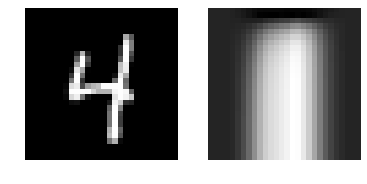

In [0]:
# test image
img = X_test[19].reshape(1, 28, 28)
_, _, z_sample = model.encoder.predict(img)
x_decoded = model.decoder.predict(z_sample)

plt.figure()
plt.subplot(121)
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(x_decoded.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

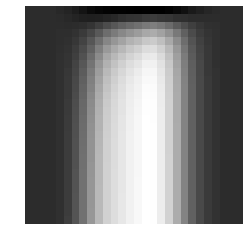

In [0]:
# random sample
z_sample = np.array([[0., 0.5]])
x_decoded = model.decoder.predict(z_sample)

plt.figure()
plt.imshow(x_decoded.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()